## Step 1: Import Libraries and Load Dataset

In [34]:
# import all necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [2]:
# load the dataset
grocery = pd.read_csv("Market Basket Analysis - Groceries_dataset.csv")
grocery.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


In [3]:
grocery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB


## Step 2: Data Preprocessing

In [4]:
grocery['Date'] = pd.to_datetime(grocery['Date'])

C:\Users\Vincent Oloyede\AppData\Local\Temp\ipykernel_1564\1644689896.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  grocery['Date'] = pd.to_datetime(grocery['Date'])


In [5]:
grocery['Year'] = grocery['Date'].dt.year
grocery['Month'] = grocery['Date'].dt.month
grocery['Day'] = grocery['Date'].dt.dayofweek
grocery.head()

,Member_number,Date,itemDescription,Year,Month,Day
0,1808,2015-07-21,tropical fruit,2015,7,1
1,2552,2015-05-01,whole milk,2015,5,4
2,2300,2015-09-19,pip fruit,2015,9,5
3,1187,2015-12-12,other vegetables,2015,12,5
4,3037,2015-01-02,whole milk,2015,1,4


In [6]:
grocery.duplicated().sum()

759

In [7]:
grocery.drop_duplicates(inplace=True)

In [8]:
grocery.columns

Index(['Member_number', 'Date', 'itemDescription', 'Year', 'Month', 'Day'], dtype='object')

## Step 3: Exploratory Data Analysis

### How many customers does the store have and how many items do they sell?

In [9]:
print("Number of Customers: ", len(grocery['Member_number'].unique()))
print("Number of items sold: ", len(grocery['itemDescription'].unique()))

Number of Customers:  3898
Number of items sold:  167


### What are the most frequently purchased items

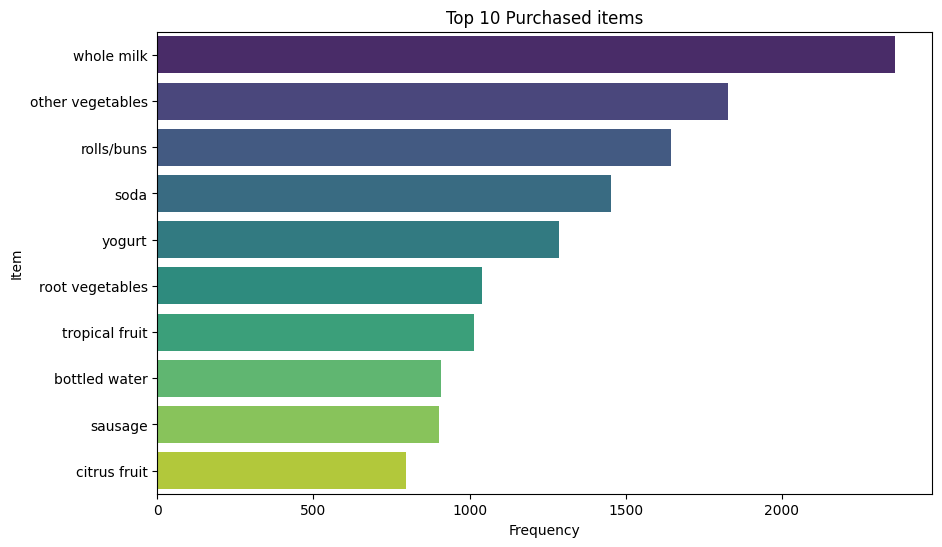

In [10]:
top_items = grocery['itemDescription'].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_items.values, y=top_items.index, palette='viridis')
plt.title("Top 10 Purchased items")
plt.xlabel("Frequency")
plt.ylabel("Item")
plt.show()

### Most Frequent customers and the top items bought by each customers

3180    35
3737    33
3050    32
2051    31
3915    30
2433    30
2625    30
2851    29
2394    29
3872    29
3308    28
4338    28
Name: Member_number, dtype: int64


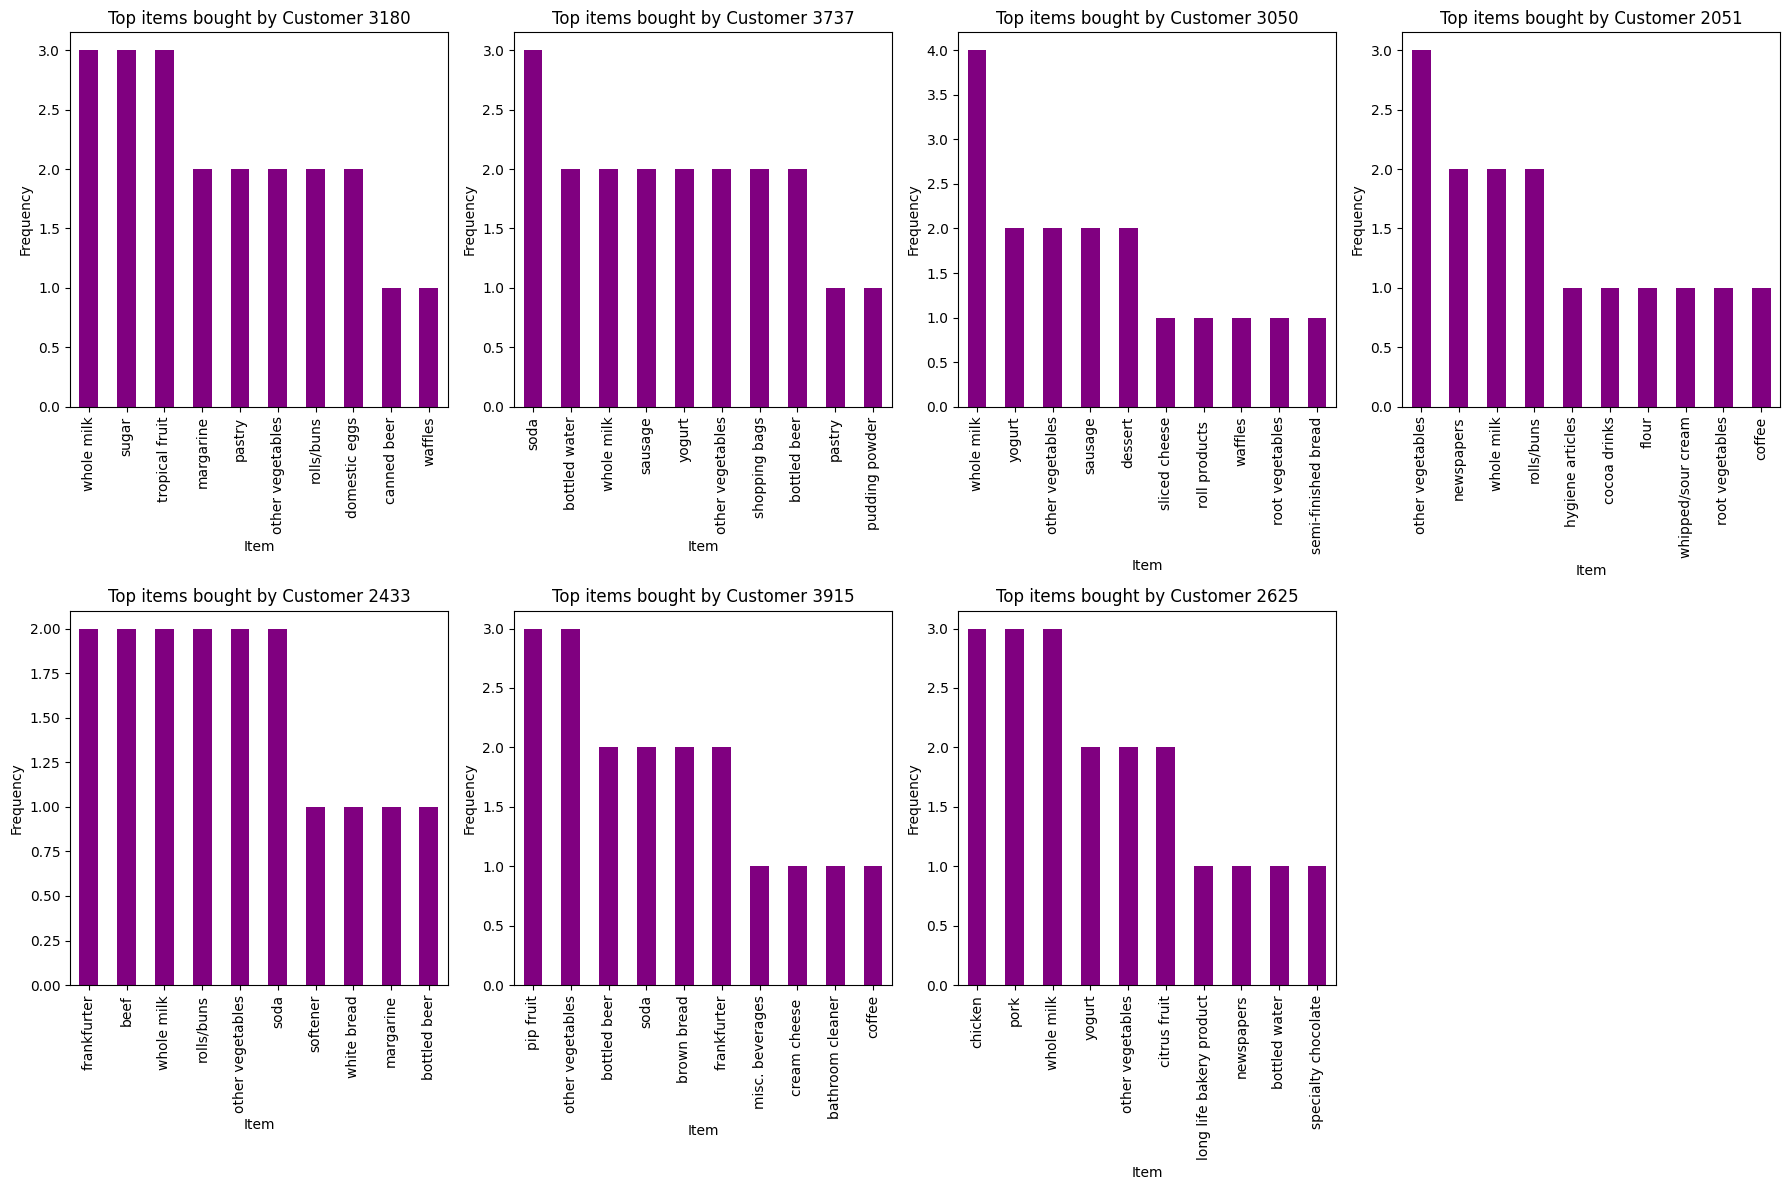

In [11]:
print(grocery['Member_number'].value_counts().head(12))

# Identify the top customers
top_customers = grocery.groupby('Member_number')['itemDescription'].count().sort_values(ascending=False).head(7).index

plt.figure(figsize=(18,12))

for customer in top_customers:
    customer_data = grocery[grocery['Member_number'] == customer]
    most_bought_items = customer_data['itemDescription'].value_counts().head(10)

    plt.subplot(2, 4, list(top_customers).index(customer) + 1)
    most_bought_items.plot(kind='bar', color='purple')
    plt.title(f'Top items bought by Customer {customer}')
    plt.xlabel('Item')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### How has the number of Transaction vary over time

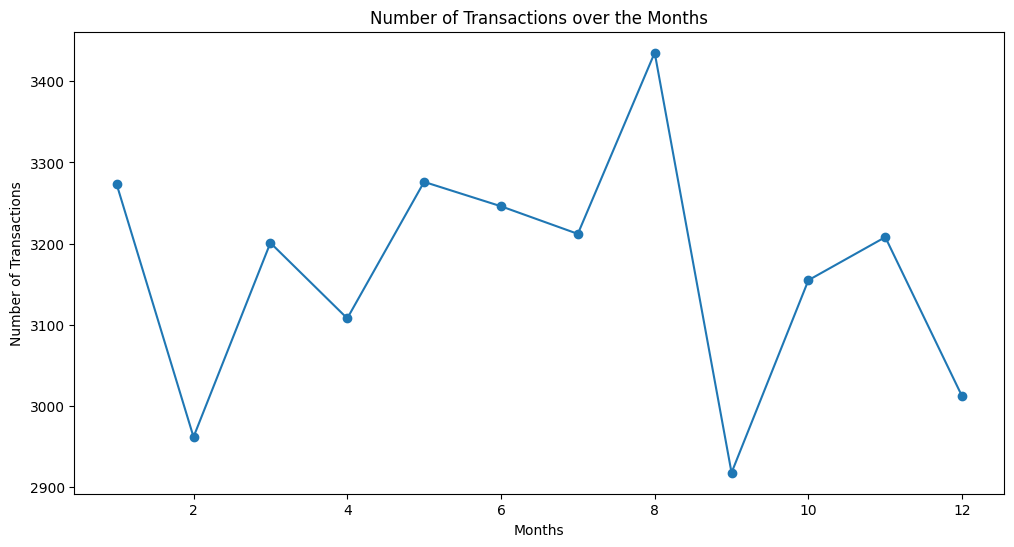

In [12]:
# number of transactions over the years

trans_per_year = grocery.groupby('Month').size()

plt.figure(figsize=(12,6))
trans_per_year.plot(marker='o')
plt.title("Number of Transactions over the Months")
plt.xlabel('Months')
plt.ylabel('Number of Transactions')
plt.show()

Text(0, 0.5, 'Number of Transactions')

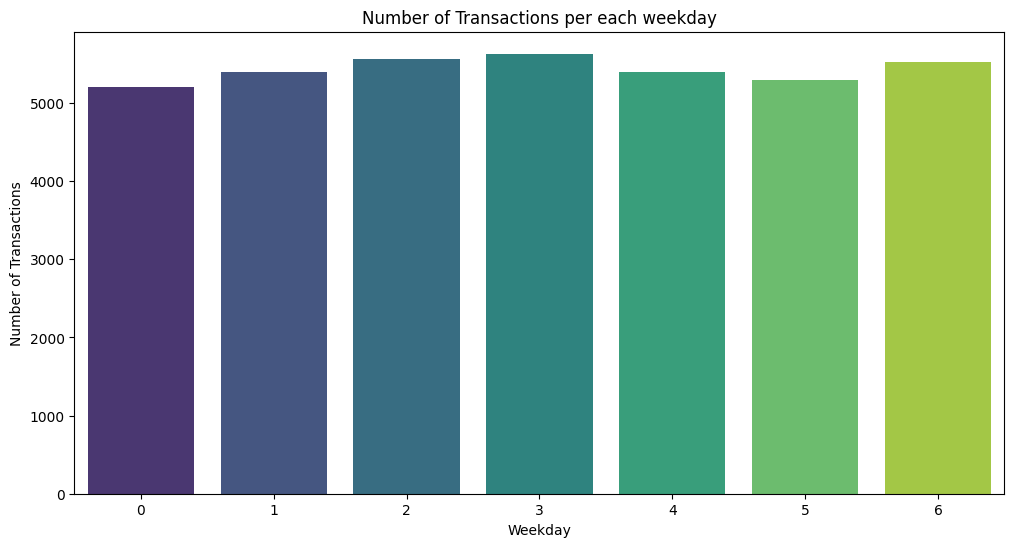

In [13]:
# throughout the days

trans_per_day = grocery.groupby("Day").size()

plt.figure(figsize=(12,6))
sns.barplot(x=trans_per_day.index, y=trans_per_day.values, palette='viridis')
plt.title("Number of Transactions per each weekday")
plt.xlabel("Weekday")
plt.ylabel("Number of Transactions")

## Step 4: Transaction Identification: Transform data into a Binary Format

In [33]:
# list items by member IDs
user_id = grocery['Member_number'].unique()
items = [list(grocery.loc[grocery['Member_number'] == id, 'itemDescription']) for id in user_id]
items[0]

['tropical fruit',
 'long life bakery product',
 'meat',
 'sugar',
 'rolls/buns',
 'semi-finished bread',
 'whole milk',
 'citrus fruit',
 'candy',
 'napkins']

In [35]:
# create a item matrix
TE = TransactionEncoder()
TE.fit(items)
item_transformed = TE.transform(items)
item_matrix = pd.DataFrame(item_transformed, columns=TE.columns_)
item_matrix.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,True,False,False


## Step 5: Calculate Support for each item using Apriori Algorithm

In [36]:
# find frequent items using Apriori Algorithm
frequent_itemsets = apriori(item_matrix, min_support=0.01, use_colnames=True, max_len=2)
frequent_itemsets.sort_values(by='support', ascending=False)

,support,itemsets
113,0.458184,(whole milk)
69,0.376603,(other vegetables)
84,0.349666,(rolls/buns)
94,0.313494,(soda)
114,0.282966,(yogurt)
...,...,...
414,0.010005,"(frankfurter, butter milk)"
705,0.010005,"(whole milk, dog food)"
882,0.010005,"(hygiene articles, newspapers)"
1106,0.010005,"(waffles, pork)"


## Step 6: Generate Association Rules

In [39]:

# Generate Association rules with confidence and lift measures
association_rules_grocery = association_rules(frequent_itemsets, metric='lift', min_threshold=1)

association_rules_grocery


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(UHT-milk),(beef),0.078502,0.119548,0.010518,0.133987,1.120775,0.001133,1.016672,0.116940
1,(beef),(UHT-milk),0.119548,0.078502,0.010518,0.087983,1.120775,0.001133,1.010396,0.122392
2,(bottled beer),(UHT-milk),0.158799,0.078502,0.014879,0.093700,1.193597,0.002413,1.016769,0.192815
3,(UHT-milk),(bottled beer),0.078502,0.158799,0.014879,0.189542,1.193597,0.002413,1.037933,0.176014
4,(bottled water),(UHT-milk),0.213699,0.078502,0.021293,0.099640,1.269268,0.004517,1.023477,0.269801
...,...,...,...,...,...,...,...,...,...,...
2113,(white wine),(whole milk),0.044125,0.458184,0.023602,0.534884,1.167400,0.003384,1.164905,0.150015
2114,(yogurt),(white wine),0.282966,0.044125,0.016419,0.058024,1.314976,0.003933,1.014754,0.334056
2115,(white wine),(yogurt),0.044125,0.282966,0.016419,0.372093,1.314976,0.003933,1.141944,0.250587
2116,(whole milk),(yogurt),0.458184,0.282966,0.150590,0.328667,1.161510,0.020940,1.068076,0.256640
